<a href="https://colab.research.google.com/github/nsambel1980/causal_discovery/blob/main/QuantileGraphHurstEstimator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Estimating Hurst exponent using quantile graph

Testing Quantile Graph Hurst Exponent Estimator
True H: 0.30, Estimated H: 0.325, Error: 0.025, R²: 0.984
True H: 0.50, Estimated H: 0.524, Error: 0.024, R²: 0.994
True H: 0.70, Estimated H: 0.683, Error: 0.017, R²: 0.997
True H: 0.90, Estimated H: 0.838, Error: 0.062, R²: 0.999

Detailed example with H = 0.7:


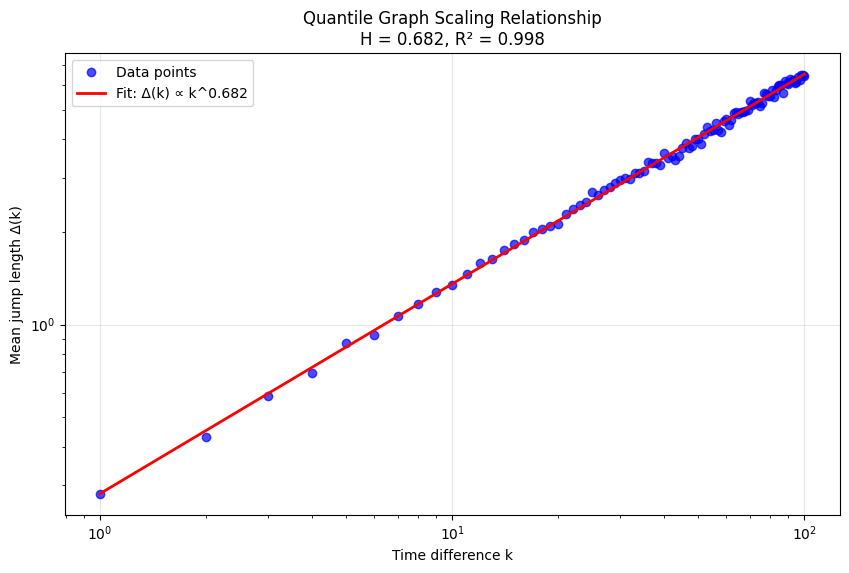

Estimated Hurst exponent: 0.6823 ± 0.0029
True Hurst exponent: 0.7
Absolute error: 0.0177
R-squared: 0.9983


In [ ]:

import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from typing import Tuple, Optional
import warnings

class QuantileGraphHurstEstimator:
    """
    Quantile Graph method for estimating Hurst exponent of self-affine time series.

    Based on the paper:
    "Hurst exponent estimation of self-affine time series using quantile graphs"
    by Campanharo & Ramos (2016)
    """

    def __init__(self, n_quantiles: int = 50, k_max: Optional[int] = None,
                 n_walks: int = 1000, random_state: Optional[int] = None):
        """
        Initialize the Quantile Graph Hurst estimator.

        Parameters:
        -----------
        n_quantiles : int, default=50
            Number of quantiles (Q) to divide the time series range
        k_max : int, optional
            Maximum time difference for transition analysis. If None, uses T//10
        n_walks : int, default=1000
            Number of random walks to perform for mean jump length calculation
        random_state : int, optional
            Random seed for reproducibility
        """
        self.n_quantiles = n_quantiles
        self.k_max = k_max
        self.n_walks = n_walks
        self.random_state = random_state
        if random_state is not None:
            np.random.seed(random_state)

    def _create_quantiles(self, time_series: np.ndarray) -> np.ndarray:
        """Create quantile boundaries for the time series."""
        return np.percentile(time_series, np.linspace(0, 100, self.n_quantiles + 1))

    def _map_to_quantiles(self, time_series: np.ndarray, quantile_bounds: np.ndarray) -> np.ndarray:
        """Map time series values to quantile indices."""
        quantile_indices = np.digitize(time_series, quantile_bounds) - 1
        # Handle edge cases
        quantile_indices = np.clip(quantile_indices, 0, self.n_quantiles - 1)
        return quantile_indices

    def _build_transition_matrix(self, quantile_indices: np.ndarray, k: int) -> np.ndarray:
        """
        Build transition matrix W_k for time difference k.

        Parameters:
        -----------
        quantile_indices : np.ndarray
            Array of quantile indices for the time series
        k : int
            Time difference

        Returns:
        --------
        np.ndarray
            Transition matrix W_k of shape (n_quantiles, n_quantiles)
        """
        W_k = np.zeros((self.n_quantiles, self.n_quantiles))

        # Count transitions from quantile i to quantile j with time difference k
        for t in range(len(quantile_indices) - k):
            i = quantile_indices[t]
            j = quantile_indices[t + k]
            W_k[i, j] += 1

        # Normalize to create transition probabilities
        row_sums = W_k.sum(axis=1)
        # Handle rows with zero sum (no transitions from that quantile)
        for i in range(self.n_quantiles):
            if row_sums[i] > 0:
                W_k[i, :] /= row_sums[i]
            else:
                # If no transitions from quantile i, use uniform distribution
                W_k[i, :] = 1.0 / self.n_quantiles

        return W_k

    def _random_walk_mean_jump_length(self, W_k: np.ndarray) -> float:
        """
        Perform random walks on the quantile graph and compute mean jump length.

        Parameters:
        -----------
        W_k : np.ndarray
            Transition matrix

        Returns:
        --------
        float
            Mean jump length Δ(k)
        """
        jump_lengths = []

        for _ in range(self.n_walks):
            # Start from random quantile
            current_node = np.random.randint(0, self.n_quantiles)

            # Perform random walk step
            if W_k[current_node, :].sum() > 0:
                next_node = np.random.choice(
                    self.n_quantiles,
                    p=W_k[current_node, :]
                )
            else:
                next_node = np.random.randint(0, self.n_quantiles)

            # Calculate jump length (distance between nodes)
            jump_length = abs(next_node - current_node)
            jump_lengths.append(jump_length)

        return np.mean(jump_lengths)

    def estimate_hurst_exponent(self, time_series: np.ndarray,
                              plot_results: bool = False) -> Tuple[float, dict]:
        """
        Estimate Hurst exponent using the Quantile Graph method.

        Parameters:
        -----------
        time_series : np.ndarray
            Input time series
        plot_results : bool, default=False
            Whether to plot the scaling relationship

        Returns:
        --------
        tuple
            (hurst_exponent, results_dict)
            where results_dict contains:
            - 'k_values': array of k values used
            - 'delta_values': array of mean jump lengths
            - 'slope': estimated slope (Hurst exponent)
            - 'intercept': y-intercept of the fit
            - 'r_squared': coefficient of determination
            - 'std_error': standard error of the slope
        """
        T = len(time_series)

        # Set k_max if not provided
        if self.k_max is None:
            self.k_max = min(T // 10, 100)

        # Create quantiles
        quantile_bounds = self._create_quantiles(time_series)
        quantile_indices = self._map_to_quantiles(time_series, quantile_bounds)

        # Calculate mean jump lengths for different k values
        k_values = []
        delta_values = []

        for k in range(1, min(self.k_max + 1, T)):
            if T - k > 10:  # Ensure enough data points for transitions
                W_k = self._build_transition_matrix(quantile_indices, k)
                delta_k = self._random_walk_mean_jump_length(W_k)

                # Skip if delta is zero or invalid
                if delta_k > 0:
                    k_values.append(k)
                    delta_values.append(delta_k)

        k_values = np.array(k_values)
        delta_values = np.array(delta_values)

        if len(k_values) < 5:
            warnings.warn("Insufficient data points for reliable Hurst estimation")

        # Fit power law: Δ(k) ~ k^H
        # Take logarithm: log(Δ(k)) = H * log(k) + log(C)
        log_k = np.log(k_values)
        log_delta = np.log(delta_values)

        # Linear regression
        slope, intercept, r_value, p_value, std_err = stats.linregress(log_k, log_delta)

        # The slope is the Hurst exponent
        hurst_exponent = slope

        # Prepare results dictionary
        results = {
            'k_values': k_values,
            'delta_values': delta_values,
            'slope': slope,
            'intercept': intercept,
            'r_squared': r_value**2,
            'std_error': std_err,
            'p_value': p_value
        }

        # Plot results if requested
        if plot_results:
            self._plot_scaling_relationship(k_values, delta_values, slope, intercept, r_value**2)

        return hurst_exponent, results

    def _plot_scaling_relationship(self, k_values: np.ndarray, delta_values: np.ndarray,
                                 slope: float, intercept: float, r_squared: float):
        """Plot the scaling relationship Δ(k) vs k."""
        plt.figure(figsize=(10, 6))

        # Original data
        plt.loglog(k_values, delta_values, 'bo', alpha=0.7, label='Data points')

        # Fitted line
        k_fit = np.logspace(np.log10(k_values.min()), np.log10(k_values.max()), 100)
        delta_fit = np.exp(intercept) * k_fit**slope
        plt.loglog(k_fit, delta_fit, 'r-', linewidth=2,
                  label=f'Fit: Δ(k) ∝ k^{slope:.3f}')

        plt.xlabel('Time difference k')
        plt.ylabel('Mean jump length Δ(k)')
        plt.title(f'Quantile Graph Scaling Relationship\nH = {slope:.3f}, R² = {r_squared:.3f}')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()


def generate_fractional_brownian_motion(n: int, hurst: float, random_state: Optional[int] = None) -> np.ndarray:
    """
    Generate fractional Brownian motion using the Davies-Harte method.

    Parameters:
    -----------
    n : int
        Length of the time series
    hurst : float
        Hurst exponent (0 < H < 1)
    random_state : int, optional
        Random seed

    Returns:
    --------
    np.ndarray
        Fractional Brownian motion time series
    """
    if random_state is not None:
        np.random.seed(random_state)

    # Generate autocovariance function
    def gamma(k, H):
        return 0.5 * (abs(k-1)**(2*H) - 2*abs(k)**(2*H) + abs(k+1)**(2*H))

    # Create circulant matrix eigenvalues
    r = np.zeros(2*n)
    r[0] = 1
    for k in range(1, n):
        r[k] = gamma(k, hurst)
        r[2*n-k] = r[k]

    # Generate complex normal variables
    z1 = np.random.normal(0, 1, n-1)
    z2 = np.random.normal(0, 1, n-1)
    z = np.concatenate([[np.random.normal(0, 1)], z1 + 1j*z2, [np.random.normal(0, 1)], z1 - 1j*z2])

    # Apply FFT
    lambda_vals = np.fft.fft(r)
    w = np.fft.fft(z * np.sqrt(lambda_vals / (2*n)))

    # Extract real part and cumulative sum
    fbm = np.real(w[:n])
    fbm = np.cumsum(fbm)

    return fbm


# Example usage and testing
if __name__ == "__main__":
    # Test with synthetic fractional Brownian motion
    print("Testing Quantile Graph Hurst Exponent Estimator")
    print("=" * 50)

    # Test different Hurst exponents
    true_hurst_values = [0.3, 0.5, 0.7, 0.9]
    n_points = 5000

    estimator = QuantileGraphHurstEstimator(n_quantiles=50, random_state=42)

    for true_H in true_hurst_values:
        # Generate synthetic fBm
        fbm = generate_fractional_brownian_motion(n_points, true_H, random_state=42)

        # Estimate Hurst exponent
        estimated_H, results = estimator.estimate_hurst_exponent(fbm, plot_results=False)

        print(f"True H: {true_H:.2f}, Estimated H: {estimated_H:.3f}, "
              f"Error: {abs(estimated_H - true_H):.3f}, R²: {results['r_squared']:.3f}")

    # Detailed example with plotting
    print("\nDetailed example with H = 0.7:")
    true_H = 0.7
    fbm = generate_fractional_brownian_motion(n_points, true_H, random_state=123)
    estimated_H, results = estimator.estimate_hurst_exponent(fbm, plot_results=True)

    print(f"Estimated Hurst exponent: {estimated_H:.4f} ± {results['std_error']:.4f}")
    print(f"True Hurst exponent: {true_H}")
    print(f"Absolute error: {abs(estimated_H - true_H):.4f}")
    print(f"R-squared: {results['r_squared']:.4f}")